# TCC Inteligência Artificial

## Machine Learning em base de dados do Cadastro Único em Belo Horizonte

### Algoritimos selecionados: DecisionTree e Random Forest

Base de dados de 2021, com aproximadamente 480.000 dados, contendo perfil das pessoas responsáveis pelo cadastro da família, em plano do governo, residentes em Belo Horizonte.

# Bibliotecas utilizadas

In [47]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from warnings import simplefilter
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
import joblib as jb
style.use('ggplot')
simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

# Carregando o dataset e criando o dataframe

In [2]:
df = pd.DataFrame()
for chunk in pd.read_csv('Cadastro_unico_BH.csv', sep = ';', na_values = '?', chunksize = 500000):
    df = pd.concat([df,chunk])

In [3]:
df.head(20)

,IDADE,GRAU_INSTRUCAO,PARENTESCO_RF,COR_RACA,SEXO,BOLSA_FAMILIA,POP_RUA,FAIXA_RENDA_FAMILIAR_PER_CAPITA
0,52.0,Fundamental incompleto,CONJUGE OU COMPANHEIRO(A),Parda,MASCULINO,SIM,NAO,Ate R$89.00
1,52.0,Fundamental incompleto,PESSOA RESPONSAVEL PELA UNIDADE FAMILIAR RF,Branca,FEMININO,SIM,NAO,Ate R$89.00
2,19.0,Fundamental incompleto,FILHO (A),Branca,MASCULINO,SIM,NAO,Ate R$89.00
3,20.0,Fundamental completo,FILHO (A),Parda,FEMININO,SIM,NAO,Ate R$89.00
4,50.0,Fundamental incompleto,PESSOA RESPONSAVEL PELA UNIDADE FAMILIAR RF,Parda,FEMININO,SIM,NAO,Ate R$89.00
5,18.0,Fundamental completo,FILHO (A),Parda,MASCULINO,SIM,NAO,Ate R$89.00
6,4.0,Nao Informado,NETO(A) OU BISNETO (A),Branca,MASCULINO,SIM,NAO,Ate R$89.00
7,78.0,Fundamental incompleto,CONJUGE OU COMPANHEIRO(A),Preta,MASCULINO,NAO,NAO,Entre R$178.01 ate 0.5 Salario Minimo
8,67.0,Fundamental incompleto,PESSOA RESPONSAVEL PELA UNIDADE FAMILIAR RF,Preta,FEMININO,NAO,NAO,Entre R$178.01 ate 0.5 Salario Minimo
9,22.0,Medio completo,FILHO (A),Branca,MASCULINO,SIM,NAO,Ate R$89.00


# Descrição das Features

 Os dados pessoais do cadastro único se referem ao representante da família maior de 16 anos.
 
 IDADE: Idade.
 
 GRAU_INSTRUCAO: Escolaridade.           
 
 PARENTESCO_RF: Papel na família.
 
 COR_RACA: Cor/Raça.
 
 SEXO: Sexo.
 
 BOLSA_FAMILIA: Se recebe bolsa família.
 
 POP_RUA: Se é morador de rua.
 
 FAIXA_RENDA_FAMILIAR_PER_CAPITA: Faixa de renda por pessoa.

# Informações do dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483803 entries, 0 to 483802
Data columns (total 8 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   IDADE                            483802 non-null  float64
 1   GRAU_INSTRUCAO                   483803 non-null  object 
 2   PARENTESCO_RF                    482461 non-null  object 
 3   COR_RACA                         483803 non-null  object 
 4   SEXO                             483803 non-null  object 
 5   BOLSA_FAMILIA                    483803 non-null  object 
 6   POP_RUA                          483803 non-null  object 
 7   FAIXA_RENDA_FAMILIAR_PER_CAPITA  483803 non-null  object 
dtypes: float64(1), object(7)
memory usage: 29.5+ MB


# Limpeza do Dataframe

In [5]:
# Exclui todas linhas de valores nulos.
df = df.dropna()

In [6]:
# # Preenchendo os valores nulos da coluna 'IDADE' com a média.
# mean = df['IDADE'].mean()
# top = mean
# df['IDADE'] = df['IDADE'].fillna(top)
# print(mean)

In [7]:
# Exclui todos registros em que a idade mínima não foi respeitada
indexNames = df[ df['IDADE'] < 16 ].index
df.drop(indexNames , inplace=True)

In [8]:
# Variáveis numéricas.
df.describe()

,IDADE
count,348265.000000
mean,42.631579
std,18.921215
min,16.000000
25%,26.000000
50%,40.000000
75%,57.000000
max,115.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 348265 entries, 0 to 483802
Data columns (total 8 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   IDADE                            348265 non-null  float64
 1   GRAU_INSTRUCAO                   348265 non-null  object 
 2   PARENTESCO_RF                    348265 non-null  object 
 3   COR_RACA                         348265 non-null  object 
 4   SEXO                             348265 non-null  object 
 5   BOLSA_FAMILIA                    348265 non-null  object 
 6   POP_RUA                          348265 non-null  object 
 7   FAIXA_RENDA_FAMILIAR_PER_CAPITA  348265 non-null  object 
dtypes: float64(1), object(7)
memory usage: 23.9+ MB


In [10]:
# Variáveis categóricas.
df.describe(include=['O'])

,GRAU_INSTRUCAO,PARENTESCO_RF,COR_RACA,SEXO,BOLSA_FAMILIA,POP_RUA,FAIXA_RENDA_FAMILIAR_PER_CAPITA
count,348265,348265,348265,348265,348265,348265,348265
unique,7,11,6,2,2,2,4
top,Fundamental incompleto,PESSOA RESPONSAVEL PELA UNIDADE FAMILIAR RF,Parda,FEMININO,NAO,NAO,Ate R$89.00
freq,125102,195296,207207,211830,228415,339645,115159


# Análise Exploratória

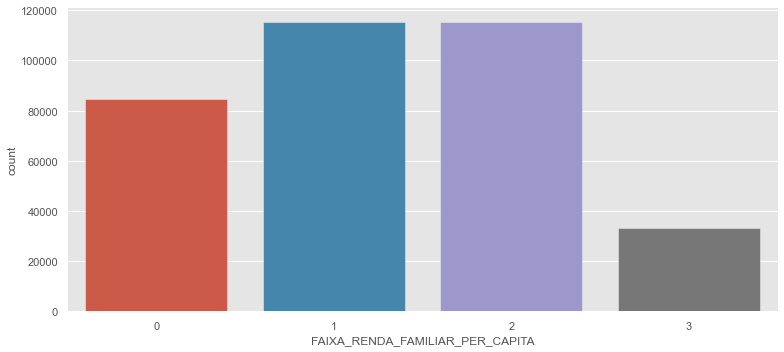

In [127]:
# Distribuição das classes (variável FAIXA_RENDA_FAMILIAR_PER_CAPITA)
sns.catplot(x='FAIXA_RENDA_FAMILIAR_PER_CAPITA',kind = 'count', data = df, orient = "h", height = 5, aspect = 2.2)

In [12]:
df['FAIXA_RENDA_FAMILIAR_PER_CAPITA'].value_counts()

Ate R$89.00                              115159
Entre R$178.01 ate 0.5 Salario Minimo    115148
Acima de 0.5 Salario Minimo               84697
Entre R$89.01 ate R$178.00                33261
Name: FAIXA_RENDA_FAMILIAR_PER_CAPITA, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6]),
 [Text(0, 0, 'Fundamental incompleto'),
  Text(1, 0, 'Fundamental completo'),
  Text(2, 0, 'Medio completo'),
  Text(3, 0, 'Sem instrucao'),
  Text(4, 0, 'Medio incompleto'),
  Text(5, 0, 'Superior incompleto ou mais'),
  Text(6, 0, 'Nao Informado')])

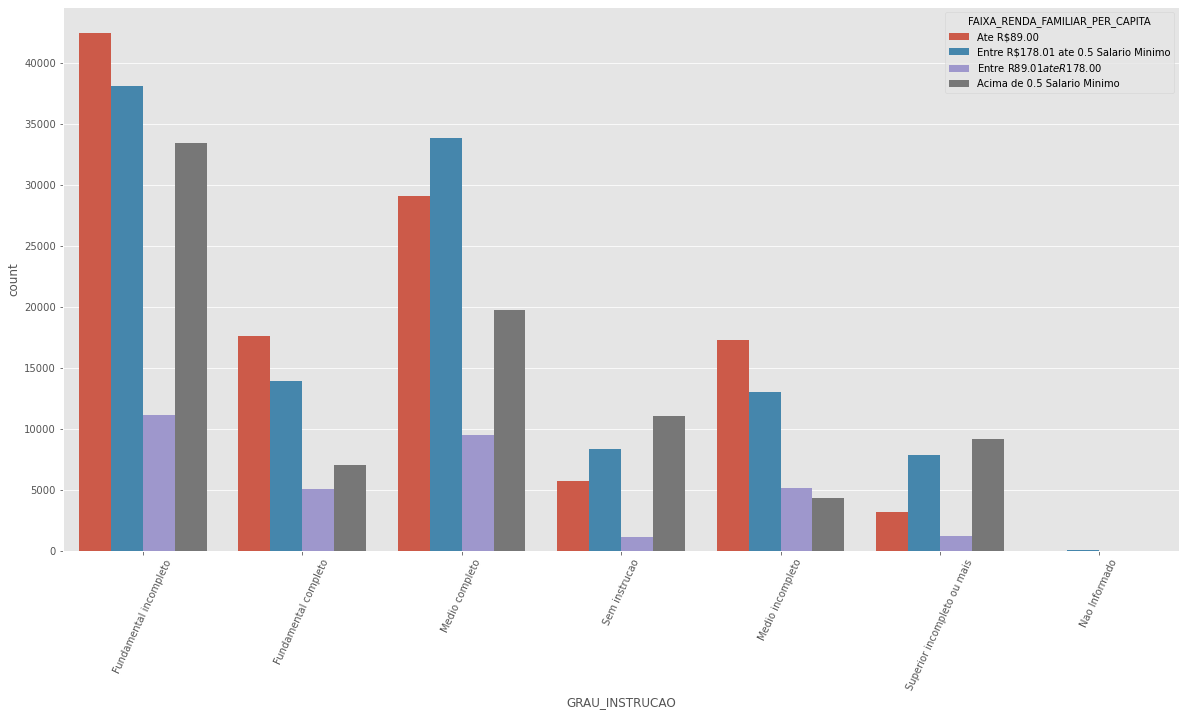

In [13]:
# Distribuição das classes por nível de escolaridade
plt.figure(figsize=(20,10))
sns.countplot(data=df, x = 'GRAU_INSTRUCAO',  hue = 'FAIXA_RENDA_FAMILIAR_PER_CAPITA')
plt.xticks(rotation=65)

In [14]:
df['GRAU_INSTRUCAO'].value_counts()

Fundamental incompleto         125102
Medio completo                  92084
Fundamental completo            43650
Medio incompleto                39795
Sem instrucao                   26152
Superior incompleto ou mais     21429
Nao Informado                      53
Name: GRAU_INSTRUCAO, dtype: int64

<AxesSubplot:xlabel='count', ylabel='SEXO'>

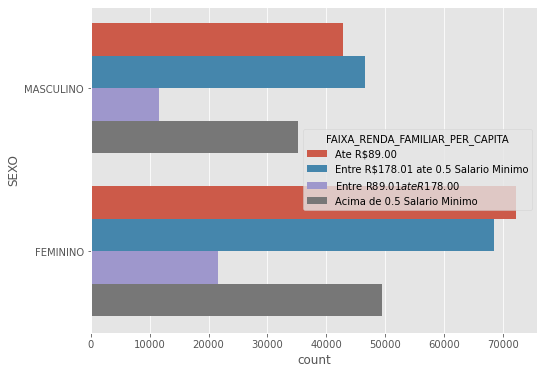

In [15]:
plt.figure(figsize=(8,6))
sns.countplot(y="SEXO", hue='FAIXA_RENDA_FAMILIAR_PER_CAPITA', data=df)

<AxesSubplot:xlabel='count', ylabel='COR_RACA'>

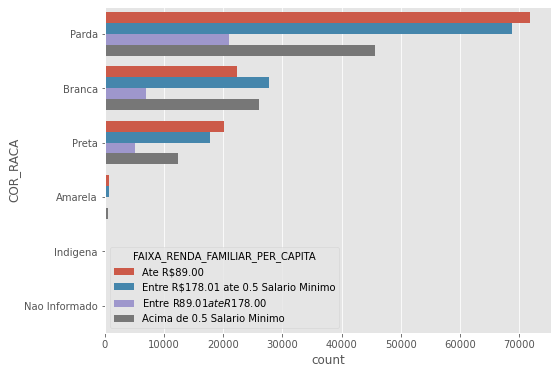

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(y="COR_RACA", hue='FAIXA_RENDA_FAMILIAR_PER_CAPITA', data=df)

In [17]:
# Verificando a idade mínima e máxima do dataset.
print(f'A idade mínima é: {df.IDADE.min()} anos')
print(f'A idade máxima é: {df.IDADE.max()} anos')

A idade mínima é: 16.0 anos
A idade máxima é: 115.0 anos


In [18]:
# Verificando a quantidade de valores nulos no dataset.
total = df.isnull().sum().sort_values(ascending=False)
percent = df.isnull().sum()/df.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, sort=False, keys=['total', 'percent'])
missing_data[missing_data['percent']!=0]

,total,percent


(array([0, 1, 2]),
 [Text(0, 0, 'JOVEM'), Text(1, 0, 'ADULTO'), Text(2, 0, 'IDOSO')])

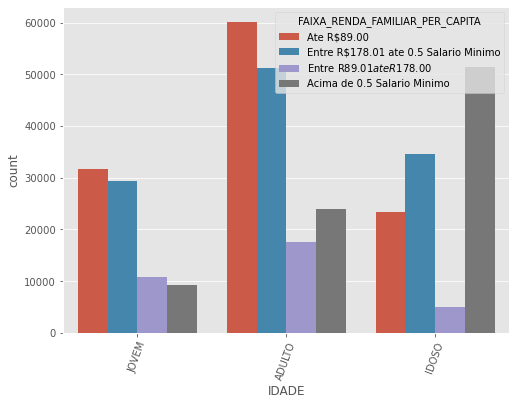

In [19]:
# Agrupamentop das idades em 3 categorias:
# 0-25 anos (JOVEM)
# 25-50 anos (ADULTO)
# 50-100 anos (IDOSO)
df['IDADE'] = pd.cut(df['IDADE'],[0,25,50,100], labels =['JOVEM','ADULTO','IDOSO'])

# Verificando distribuição.
plt.figure(figsize=(8,6))
sns.countplot(data=df, x = 'IDADE',  hue = 'FAIXA_RENDA_FAMILIAR_PER_CAPITA')
plt.xticks(rotation=70)

# Transformação dos dados

In [20]:
# Verificando se ainda existem valores nulos no Dataset.
if df.isnull().sum().sort_values(ascending=False).any() != 0:
    print(f'Existe valores nulos no dataset? {True}')
else:
    print(f'Existe valores nulos no dataset? {False}')

Existe valores nulos no dataset? True


In [21]:
# Trasnformando as variáveis categóricas em numéricas.
cols = df[df.select_dtypes(['object']).columns]

for c in cols:
    encoding = LabelEncoder()
    encoding.fit(list(df[c].values))
    df[c] = encoding.transform(list(df[c].values))
df = pd.get_dummies(df)

In [22]:
df.head(20)

,GRAU_INSTRUCAO,PARENTESCO_RF,COR_RACA,SEXO,BOLSA_FAMILIA,POP_RUA,FAIXA_RENDA_FAMILIAR_PER_CAPITA,IDADE_JOVEM,IDADE_ADULTO,IDADE_IDOSO
0,1,0,4,1,1,0,1,0,0,1
1,1,9,1,0,1,0,1,0,0,1
2,1,2,1,1,1,0,1,1,0,0
3,0,2,4,0,1,0,1,1,0,0
4,1,9,4,0,1,0,1,0,1,0
5,0,2,4,1,1,0,1,1,0,0
7,1,0,5,1,0,0,2,0,0,1
8,1,9,5,0,0,0,2,0,0,1
9,2,2,1,1,1,0,1,1,0,0
10,0,9,4,0,1,0,1,0,0,1


# Matriz de correlação

<AxesSubplot:>

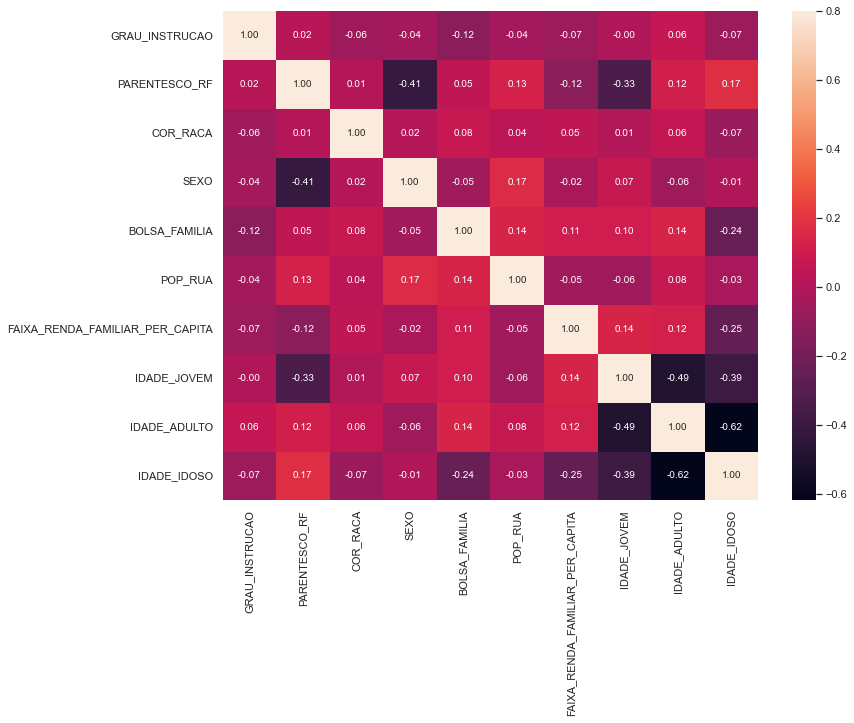

In [23]:
# Análise simultânea da associação entre variáveis.
corr = df.corr()
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8,annot_kws={'size': 10}, annot=True, fmt='.2f')

In [24]:
corr_list = corr['FAIXA_RENDA_FAMILIAR_PER_CAPITA'].sort_values(axis=0,ascending=False).iloc[1:]
corr_list

IDADE_JOVEM       0.138330
IDADE_ADULTO      0.121792
BOLSA_FAMILIA     0.105488
COR_RACA          0.047906
SEXO             -0.020906
POP_RUA          -0.051335
GRAU_INSTRUCAO   -0.067430
PARENTESCO_RF    -0.115062
IDADE_IDOSO      -0.252610
Name: FAIXA_RENDA_FAMILIAR_PER_CAPITA, dtype: float64

# Verificando as features mais importantes para o modelo.

In [25]:
# Separando a classe dos dados.
previsores = df.drop('FAIXA_RENDA_FAMILIAR_PER_CAPITA',axis=1)
classe = df['FAIXA_RENDA_FAMILIAR_PER_CAPITA']

In [26]:
clf = RandomForestClassifier(n_estimators = 100, random_state = 7)
clf.fit(previsores, classe)

RandomForestClassifier(random_state=7)

In [28]:
feature_imp = pd.Series(clf.feature_importances_,index=previsores.columns).sort_values(ascending=False)
feature_imp

BOLSA_FAMILIA     0.729439
IDADE_IDOSO       0.076500
PARENTESCO_RF     0.058806
GRAU_INSTRUCAO    0.040784
POP_RUA           0.029024
IDADE_ADULTO      0.020758
IDADE_JOVEM       0.020631
SEXO              0.013475
COR_RACA          0.010583
dtype: float64

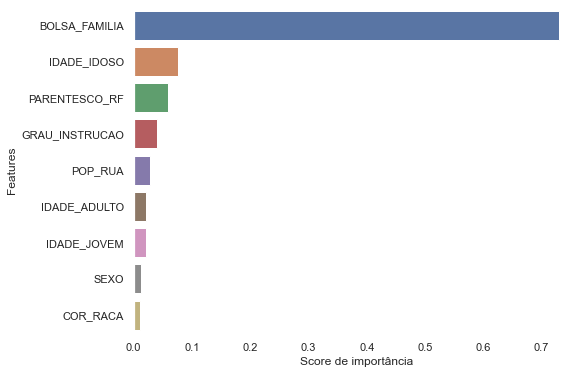

In [29]:
plt.figure(figsize=(8,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Score de importância')
plt.ylabel('Features')
plt.title("")
plt.show()

In [30]:
# Selecionando as features de maior importância.
features_selected = []
for feature,importance in feature_imp.iteritems():
    if importance > 0.03:
        print(f'{feature}: {round(importance * 100)}%')
        features_selected.append(feature)

BOLSA_FAMILIA: 73%
IDADE_IDOSO: 8%
PARENTESCO_RF: 6%
GRAU_INSTRUCAO: 4%


In [31]:
# Treinando os modelos utilizando apenas as features selecionadas.
previsores = df[features_selected]
classe = df['FAIXA_RENDA_FAMILIAR_PER_CAPITA']

# Testando os modelos de Machine Learning

In [32]:
# Criando modelo de Machine Learning a partir de cada algoritmo
# Os dados estão em diferentes escalas e isso pode prejudicar a performance de alguns algoritmos.
# Aplicando a padronização ao conjunto de dados (colocando-os na mesma escala).
# Os dados serão transformados de modo que estejam com uma distribuição normal, com média igual a zero e
# desvio padrão igual a 1.

# Não foi utilizado o modelo SVC, pois ele não funciona bem quando se tem um grande conjunto de dados
# porque o tempo de treinamento necessário é maior. 

pipelines = []
pipelines.append(('Scaled-LR', Pipeline([('Scaler', StandardScaler()),('LR', LogisticRegression())]))),
pipelines.append(('Scaled-KNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsClassifier())]))),
pipelines.append(('Scaled-CART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeClassifier())]))),
pipelines.append(('Scaled-NB', Pipeline([('Scaler', StandardScaler()),('NB', GaussianNB())]))),
#pipelines.append(('Scaled-SVM', Pipeline([('Scaler', StandardScaler()),('SVM', SVC())])))
pipelines.append(('Scaled-RF', Pipeline([('Scaler', StandardScaler()),('RF', RandomForestClassifier())])))
resultados = []
nomes = []

# Percorrendo cada um dos modelos
for nome, modelo in pipelines:
    kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)
    cross_val_result = model_selection.cross_val_score(modelo, 
                                                     previsores, 
                                                     classe, 
                                                     cv = kfold, 
                                                     scoring = 'accuracy')
    resultados.append(cross_val_result)
    nomes.append(nome)
    texto = "%s: %f (%f)" % (nome, cross_val_result.mean(), cross_val_result.std())
    print(texto)

Scaled-LR: 0.626546 (0.002541)
Scaled-KNN: 0.577658 (0.024157)
Scaled-CART: 0.632053 (0.002940)
Scaled-NB: 0.568848 (0.001471)
Scaled-RF: 0.632030 (0.002956)


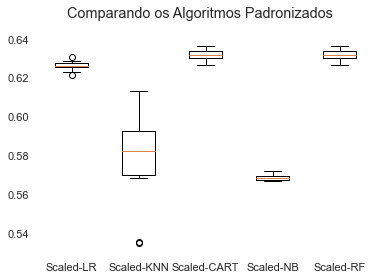

In [33]:
# De acordo com os resultados anteriores, os modelos criados com DecisionTree e Random Forest apresentaram 
# os melhores valores de acurácia e portanto os melhores resultados.
# Isso pode ser confirmado, comparando os algoritmos através de boxplots.
fig = plt.figure()
fig.suptitle('Comparando os Algoritmos Padronizados')
ax = fig.add_subplot(111)
plt.boxplot(resultados)
ax.set_xticklabels(nomes)
plt.show()

# Ajustando os modelos criados com Random Forest e DecisionTree.

In [34]:
# Embora o Random Forest tenha apresentado a menor taxa de erro após a padronização dos dados, podemos ainda otimizá-lo
# com o ajuste dos parâmetros.

# # Definindo a escala
scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)

# Possíveis valores de estimators
val_estimators = [20, 50, 100, 150, 200]

# Possíveis valores para o critério de divisão
val_criterion = ['gini', 'entropy']

# Definindo um dicionário que recebe as listas de parâmetros e valores
parametros_grid = dict(n_estimators = val_estimators,
                       criterion = val_criterion)
                      
                       
# Criando o modelo
modelo_random = RandomForestClassifier()

# Definindo K
kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)

# Testando diferenets combinações com os parâmetros
grid = RandomizedSearchCV(estimator = modelo_random, param_distributions = parametros_grid, cv = kfold, scoring = 'accuracy')
grid.fit(previsores, classe)

# Print do resultado
print("Grid scores on development set:")
means = grid.cv_results_['mean_test_score'].round(5)
stds = grid.cv_results_['std_test_score'].round(5)

for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print(f'mean:{mean},std:{std},params:{params}')
print()
print(f'Melhor parâmetro:{grid.best_params_}, Score:{grid.best_score_}')

Grid scores on development set:
mean:0.63205,std:0.00294,params:{'n_estimators': 20, 'criterion': 'gini'}
mean:0.63202,std:0.00293,params:{'n_estimators': 50, 'criterion': 'gini'}
mean:0.63201,std:0.00296,params:{'n_estimators': 100, 'criterion': 'gini'}
mean:0.63201,std:0.00294,params:{'n_estimators': 150, 'criterion': 'gini'}
mean:0.63202,std:0.00294,params:{'n_estimators': 200, 'criterion': 'gini'}
mean:0.63197,std:0.00296,params:{'n_estimators': 20, 'criterion': 'entropy'}
mean:0.632,std:0.00297,params:{'n_estimators': 50, 'criterion': 'entropy'}
mean:0.63203,std:0.00298,params:{'n_estimators': 100, 'criterion': 'entropy'}
mean:0.63202,std:0.00298,params:{'n_estimators': 150, 'criterion': 'entropy'}
mean:0.63202,std:0.00296,params:{'n_estimators': 200, 'criterion': 'entropy'}

Melhor parâmetro:{'n_estimators': 20, 'criterion': 'gini'}, Score:0.6320503043824179


In [35]:
# Ajustae dos parâmeros do DecisionTree.

# Definindo a escala
scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)

# Definindo a profundidade máxima da árvore.
max_depth = list(range(1, 31))

# Possíveis valores para o critério de divisão
val_criterion = ['gini', 'entropy']


# Definindo um dicionário que recebe as listas de parâmetros e valores
valores_grid = dict(criterion = val_criterion,
                    max_depth = max_depth)

# Criando o modelo
tree = DecisionTreeClassifier()

# Definindo K
kfold = StratifiedKFold(n_splits=10, shuffle = True, random_state=7)

# Testando diferenets combinações com os valores de K
grid = RandomizedSearchCV(estimator = tree, param_distributions = valores_grid, cv = kfold, scoring = 'accuracy')
grid.fit(previsores, classe)

# Print do resultado  
print("Grid scores on development set:")
means = grid.cv_results_['mean_test_score'].round(5)
stds = grid.cv_results_['std_test_score'].round(5)

for mean, std, params in zip(means, stds, grid.cv_results_['params']):
    print(f'mean:{mean},std:{std},params:{params}')
print()
print(f'Melhor parâmetro:{grid.best_params_}, Score:{grid.best_score_}')

Grid scores on development set:
mean:0.63206,std:0.00294,params:{'max_depth': 25, 'criterion': 'entropy'}
mean:0.63205,std:0.00295,params:{'max_depth': 10, 'criterion': 'gini'}
mean:0.63206,std:0.00294,params:{'max_depth': 15, 'criterion': 'entropy'}
mean:0.63206,std:0.00294,params:{'max_depth': 18, 'criterion': 'entropy'}
mean:0.63205,std:0.00294,params:{'max_depth': 14, 'criterion': 'gini'}
mean:0.63205,std:0.00294,params:{'max_depth': 13, 'criterion': 'gini'}
mean:0.63204,std:0.0027,params:{'max_depth': 6, 'criterion': 'gini'}
mean:0.63207,std:0.00291,params:{'max_depth': 8, 'criterion': 'entropy'}
mean:0.63206,std:0.00294,params:{'max_depth': 20, 'criterion': 'entropy'}
mean:0.63206,std:0.00294,params:{'max_depth': 27, 'criterion': 'entropy'}

Melhor parâmetro:{'max_depth': 8, 'criterion': 'entropy'}, Score:0.6320675331371991


# Finalizando o Modelo

O modelo criado com DecisionTree apresentou a melhor acurária entre todos os modelos criados e portanto será usado na construção da versão final do modelo preditivo.


In [98]:
# Preparando a versão final do modelo.
scaler = StandardScaler()
previsores = scaler.fit_transform(previsores)
modelo_tree = DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=7)
modelo_tree.fit(previsores,classe)
result_tree = cross_val_predict(modelo_tree,previsores, classe, cv=10)

print(f'Acurácia: {accuracy_score(classe,result_tree)}')
print('\n',confusion_matrix(classe,result_tree))
print('\n',classification_report(classe,result_tree))

Acurácia: 0.6312405782952637

 [[50716   374 33607     0]
 [ 6666 91330 17132    31]
 [31259  6102 77785     2]
 [ 2957 21988  8308     8]]

               precision    recall  f1-score   support

           0       0.55      0.60      0.58     84697
           1       0.76      0.79      0.78    115159
           2       0.57      0.68      0.62    115148
           3       0.20      0.00      0.00     33261

    accuracy                           0.63    348265
   macro avg       0.52      0.52      0.49    348265
weighted avg       0.59      0.63      0.60    348265



In [137]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 240

<Figure size 9600x9600 with 0 Axes>

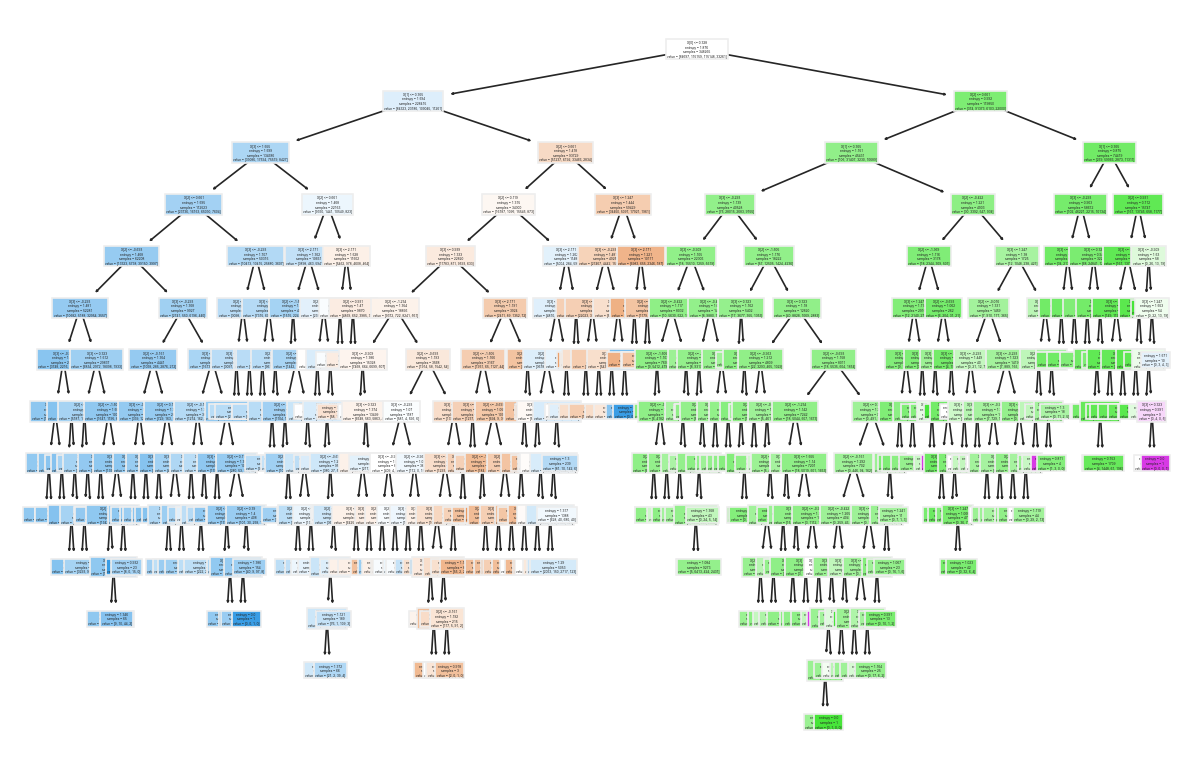

In [139]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,40))
from sklearn.tree import plot_tree

plt.figure()
plot_tree(modelo_tree, filled=True)
plt.show()

# Fazendo a persistência do modelo treinado para o disco.

In [43]:
#filename = 'model_final.sav'
pickle.dump(modelo_tree, open('modelo-05.04.sav', 'wb'))
pickle.load(open('modelo-05.04.sav', 'rb'))

DecisionTreeClassifier(criterion='entropy', max_depth=14, random_state=7)

In [44]:
#from joblib import dump, load

In [45]:
jb.dump(modelo_tree, 'modelo-05.04.pkl')

['modelo-05.04.pkl']